In [24]:
import cv2
import easyocr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm


/cosma/home/durham/dc-fras4/.conda/envs/LUS/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:

def extract_frame(video_path, frame_number=0):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # print(f"Total frames: {total_frames}")
    # print(f"FPS: {fps}")
    
    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read frame
    ret, frame = cap.read()
    
    if not ret:
        print("Error: Could not read frame.")
    
    # Release video capture object
    cap.release()

    return frame, total_frames, fps

# Usage examples
video_path = '/cosma7/data/dp004/rrtx34/ultrasound/JCUH/001/JCUH001_LUS_4/20230517_191956_0003.AVI'

# Extract single frame (frame 10)
frame, total_frames, fps = extract_frame(video_path, 10)


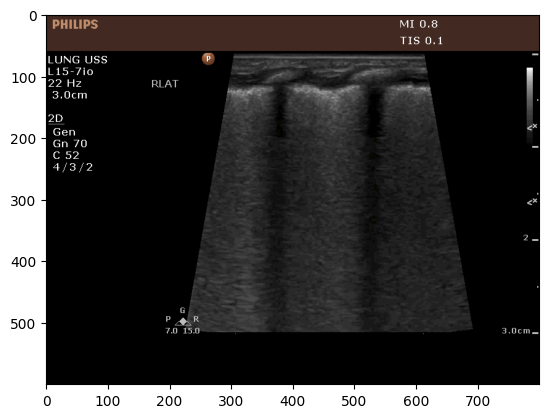

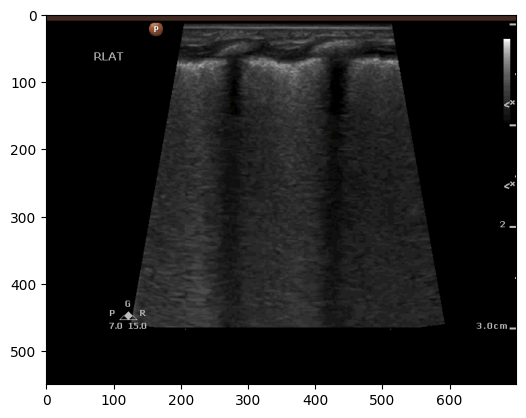

In [26]:

plt.imshow(frame)
plt.show()

# frame_cut = frame[110:280,:300]
# plt.imshow(frame_cut)

scan_label_cut = frame[50:, 100:]
plt.imshow(scan_label_cut)

/cosma/home/durham/dc-fras4/.conda/envs/LUS/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[('RLAT', np.float64(0.9997323155403137)),
 ('ZR', np.float64(0.22488578742429213)),
 ('70', np.float64(0.9998964889092362)),
 ('1520', np.float64(0.6092913150787354)),
 ('3Ocmg', np.float64(0.29389204981098194))]

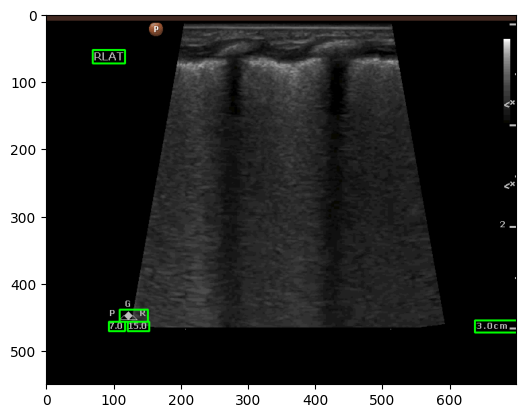

In [27]:
import easyocr
import cv2
import numpy as np

def read_text(image_path, min_confidence=0.0):
    # Initialize reader for English only
    reader = easyocr.Reader(['en'], gpu=True, verbose=False)
    
    if not isinstance(image_path, np.ndarray):
        # Read image
        print("read image")
        image = cv2.imread(image_path)
    else:
        image = image_path
    
    # Perform OCR - lowered text_threshold to catch more detections
    results = reader.readtext(
        image,
        detail=1,
        allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789/',
        text_threshold=0.1,  # Lower threshold to catch more text
        paragraph=False
    )
    
    # Draw results on image and print text
    detected_texts = []
    for (bbox, detected_text, prob) in results:
        # Only include results above minimum confidence
        if prob < min_confidence:
            continue
            
        # Get corner points
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))
        
    #     # Draw rectangle and text
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    #     cv2.putText(image, detected_text, (top_left[0], top_left[1] - 10),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    
        detected_texts.append((detected_text, prob))
        # print(f"Text: {detected_text} (Confidence: {prob:.2f})")
    
    # Display result
    # cv2.imshow("Result", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    plt.imshow(image)
    return detected_texts

# Usage
image_path = scan_label_cut
read_text(image_path, min_confidence=0.0)  # Set to 0.0 to see all detections

In [28]:
# get scan label from detected texts
# detected_texts = read_text(image_path, min_confidence=0.0)
# scan_label = None
possibilities = ['RUA', 'RLA', 'RLAT', 'RUP', 'RLP', 'LUA', 'LLA', 'LLP', 'LUP', 'LLP', 'RAA', 'RAB', 'RLT', 'RPA', 'RPB', 'LAA', 'LAB', 'LLAT', 'LLT', 'LPA', 'LPB', 'RLATERAL', 'RAX', 'LLATERAL', 'LAX']

def find_scan_label(detected_texts, possibilities):
    for text, prob in detected_texts:
        if text in possibilities:
            if prob >= 0.5:  # confidence threshold
                return text
    return None

# scan_label = find_scan_label(detected_texts, possibilities)
# if scan_label:
#     print("Scan label:", scan_label)
# else:
#     print("No scan label")





Directory exists: True -> /cosma7/data/dp004/rrtx34/ultrasound/JCUH
Sample entries: ['034', '024', '011', '018', '021']


Extracting scan labels (OCR):   2%|▏         | 29/1595 [01:29<1:20:22,  3.08s/it]



KeyboardInterrupt: 

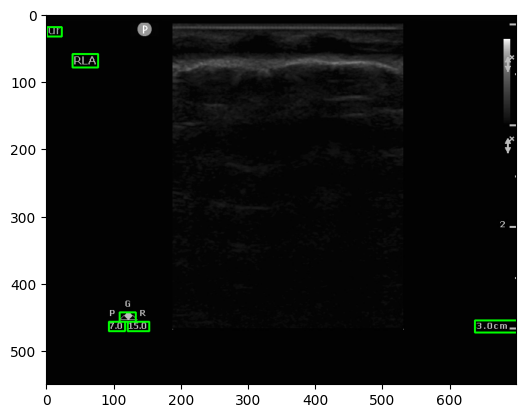

In [29]:


# Set the directory path
dir_path = r'/cosma7/data/dp004/rrtx34/ultrasound/JCUH'

# Diagnostics
print(f"Directory exists: {os.path.exists(dir_path)} -> {dir_path}")
if os.path.exists(dir_path):
    try:
        print("Sample entries:", os.listdir(dir_path)[:5])
    except Exception as e:
        print("Could not list directory contents:", e)

# Create an empty list to store the file names and paths
file_list = []

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(dir_path):
    files = [ fi for fi in files if fi.endswith(".AVI") or fi.endswith(".MP4") ]
    for file in tqdm(files, desc=f"Indexing videos in {os.path.basename(root)}", leave=False):
        # Get the file path
        file_path = os.path.join(root, file)
        scan_no = os.path.split(os.path.dirname(file_path))[-1]
        patient_id = os.path.split(os.path.dirname(os.path.dirname(file_path)))[-1]
        # Append the file name and path to the list
        file_list.append({'Hospital': 'JCUH', 'File Path': file_path, 'Patient ID': patient_id, 'Scan No': scan_no[8:13]})

# add scan label column
for file_info in tqdm(file_list, desc="Extracting scan labels (OCR)"):
    video_path = file_info['File Path']
    frame, total_frames, fps = extract_frame(video_path, frame_number=10)
    
    scan_label_cut = frame[50:, 100:]
    detected_texts = read_text(scan_label_cut, min_confidence=0.0)
    scan_label = find_scan_label(detected_texts, possibilities)
    file_info['Scan Label'] = scan_label if scan_label else 'Unknown'
    
    if file_info['Scan No']=='LUS_4':
        file_info['Scan No'] = 'LU_4'

    # Add frames and FPS information
    file_info['Total Frames'] = total_frames
    file_info['FPS'] = fps


# Create a Pandas DataFrame from the list
df_path = pd.DataFrame(file_list)

In [ ]:
# Change scan label to expert scan label
def to_expert_label(label: str) -> str:
    s = str(label).upper()
    if s in ("RLAT", "RLATERAL", "RAX", "RLT"):
        return "Rax"
    if s == "RUA":
        return "RAA"
    if s == "RLA":
        return "RAB"
    if s == "RUP":
        return "RPA"
    if s == "RLP":
        return "RPB"
    if s == "LUA":
        return "LAA"
    if s == "LLA":
        return "LAB"
    if s in ("LLAT", "LLATERAL", "LAX", "LLT"):
        return "LAX"
    if s == "LUP":
        return "LPA"
    if s == "LLP":
        return "LPB"
    return label

df_path["Scan Label"] = df_path["Scan Label"].apply(to_expert_label)

In [ ]:
# Add score
scores_directory = '/cosma7/data/dp004/rrtx34/ultrasound/Virginie_scores/Scores_JCUH'

def add_scores(df, scores_directory):
    # find patient score file
    for i in tqdm(df.index, desc="Adding scores"):
        patient_id = df.at[i, 'Patient ID']
        scan_no = df.at[i, 'Scan No']
        scan_label = df.at[i, 'Scan Label']
        for file in os.listdir(scores_directory):
            if file.endswith(f"{patient_id}.xlsx"):
                df_score = pd.ExcelFile(os.path.join(scores_directory, file))
                sheets = df_score.sheet_names
                df_score = pd.read_excel(df_score, sheet_name=sheets[-1])
        # clean score data frames to remove empty rows and columns
        for col in df_score.columns:
            if df_score[col].isnull().all():
                df_score = df_score.drop(columns=[col])

        for index, row in df_score.iterrows():
            if row.isnull().all():
                df_score = df_score.drop(index=index)

        # make first row and column header
        df_score.columns = df_score.iloc[0]
        df_score = df_score[1:]
        df_score = df_score.set_index(df_score.columns[0])

        # add score to main dataframe
        if scan_label in df_score.index and scan_no in df_score.columns:
            score = df_score.at[scan_label, scan_no]
            df.at[i, 'Score'] = score

    return df
        
df_path = add_scores(df_path, scores_directory)
                

In [ ]:
print(df_path)
df_path.to_csv('LUS_data.csv')

   Hospital                                          File Path Patient ID  \
0      JCUH  /cosma7/data/dp004/rrtx34/ultrasound/JCUH/001/...        001   
1      JCUH  /cosma7/data/dp004/rrtx34/ultrasound/JCUH/001/...        001   
2      JCUH  /cosma7/data/dp004/rrtx34/ultrasound/JCUH/001/...        001   
3      JCUH  /cosma7/data/dp004/rrtx34/ultrasound/JCUH/001/...        001   
4      JCUH  /cosma7/data/dp004/rrtx34/ultrasound/JCUH/001/...        001   
5      JCUH  /cosma7/data/dp004/rrtx34/ultrasound/JCUH/001/...        001   
6      JCUH  /cosma7/data/dp004/rrtx34/ultrasound/JCUH/001/...        001   
7      JCUH  /cosma7/data/dp004/rrtx34/ultrasound/JCUH/001/...        001   
8      JCUH  /cosma7/data/dp004/rrtx34/ultrasound/JCUH/001/...        001   
9      JCUH  /cosma7/data/dp004/rrtx34/ultrasound/JCUH/001/...        001   
10     JCUH  /cosma7/data/dp004/rrtx34/ultrasound/JCUH/001/...        001   
11     JCUH  /cosma7/data/dp004/rrtx34/ultrasound/JCUH/001/...        001   

In [ ]:
# score = '/cosma7/data/dp004/rrtx34/ultrasound/Virginie_scores/Scores_JCUH/JCUH008.xlsx'
# df_score = pd.ExcelFile(score)
# sheets = df_score.sheet_names
# df_score = pd.read_excel(df_score, sheet_name=sheets[-1])

# # clean score data frames to remove empty rows and columns
# for col in df_score.columns:
#     if df_score[col].isnull().all():
#         df_score = df_score.drop(columns=[col])

# for index, row in df_score.iterrows():
#     if row.isnull().all():
#         df_score = df_score.drop(index=index)

# # make first row and column header
# df_score.columns = df_score.iloc[0]
# df_score = df_score[1:]
# df_score = df_score.set_index(df_score.columns[0])

# print(df_score)
# print(df_score.index)
# print(df_score.columns)